### Proyecto: Scoring crediticio automatizado No dar Papaya
---
 - Análisis de Riesgo de posible incumplimiento
 - **Notebook**: by Edwar Mayorga.
 - **Url**: https://github.com/emmllanitos
 - **Fecha de Creación**: Junio 2023

### Introducción
---

Este proyecto consiste en **automatizar** un informe para la división de préstamos de un Banco Papaya.

El informe se tendrá en cuenta al crear una **puntuación de crédito** para un cliente potencial. La **puntuación de crédito** se utiliza para evaluar la capacidad de que un cliente  pueda pagar su préstamo.

### Propósito del Proyecto
---

Dar a conocer si un cliente puede ser acreedor o no a una línea de crédito por parte del Banco Papaya de acuerdo a una serie de características personales y profesionales registradas por la entidad financiera.

### Descripción de los datos
---

El dataset es un historico de datos de posibles clientes que brindaron su informacion aceptando su tratamiento bajo politicas del Banco Papaya en la **solicitud** de credito

- **children** - el número de hijos en la familia
- **days_employed** - experiencia laboral en días
- **dob_years** - la edad del cliente en años
- **education** - la educación del cliente
- **education_id** - identificador de educación
- **family_status** - estado civil
- **family_status_id** - identificador de estado civil
- **gender** - género del cliente
- **income_type** - tipo de empleo
- **debt** - ¿había alguna deuda en el pago de un préstamo?
- **total_income** - ingreso mensual
- **purpose** - el propósito de obtener un préstamo

### Modulo 1: Exploración de Datos
---

Vamos a comenzar con la exploracion de datos, conocer la informacion que contienen y analisis de la misma.

Primero iniciaremos con la **Carga de Librerias**

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Lectura de Datos

In [2]:
dataset = 'data/CreditScoring.csv'

df = pd.read_csv(dataset)

Informacion de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Vistazo inicial de los datos

In [4]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,145885.952297,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding


Segun el resultado de la info, se envidencia que algunas columnas tienen datos con nulos o tipo NaN, entonces vamos a encontrarlas y tratarlas.

In [5]:
df[df.isna().any(axis=1)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Secondary Education,1,married,0,M,partner,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21497,0,NaN,48,MASTERS DEGREE,0,married,0,F,partner,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


In [6]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Se evidencia que la columna Dias laborados y Ingresos mensuales estan con vacios, esto quiere decir que las personas que no tienen experiencia laboral tampoco registran un ingreso mensual.

**Supuesto 1** 

Lo anterior probablemente tenga una relación con el nivel de educación ya que una educación deficiente o de bajo nivel tiene como consecuencias desempleo y/o empleos no formales, para ello, vamos a investigar a los clientes que no tienen datos sobre la característica identificada y la columna con los valores ausentes.

**Análisis de Educación**

In [7]:
df['education'].unique()

array(['masters degree', 'secondary education', 'Secondary Education',
       'SECONDARY EDUCATION', 'MASTERS DEGREE', 'bachelor degree',
       'primary education', 'Masters Degree', 'BACHELOR DEGREE',
       'Bachelor Degree', 'PRIMARY EDUCATION', 'Primary Education',
       'Academic Degree', 'ACADEMIC DEGREE', 'academic degree'],
      dtype=object)

Existen datos duplicados que contienen el mismo grado escolar pero escritos en mayúsculas y minúsculas, demosle formato para tener un resultado más preciso.

In [8]:
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['masters degree', 'secondary education', 'bachelor degree',
       'primary education', 'academic degree'], dtype=object)

**Filtrando Tabla**

Una vez limpios nuestros datos haremos un filtro para conocer los valores ausentes en el nivel de educación secundaria

In [9]:
df[df['education'] == 'secondary education']['days_employed'].value_counts(dropna=False)

days_employed
 NaN              1540
-4024.803754         1
 400147.947311       1
-3507.818775         1
-635.915050          1
                  ... 
-5730.178239         1
-429.448441          1
-1613.140030         1
-452.930653          1
-1984.507589         1
Name: count, Length: 13694, dtype: int64

Nuestros datos nos indican que existen un total de **13,694** registros de nivel de **educación secundaria**, de los cuales hay un total de 1,540 datos sobre los valores ausentes, ahora, comprobemos la distribución entre los datos ausentes de nivel secundaria y el total de clientes.

In [10]:
nan_data = 2174
nan_sec_edu = 1540

total_dis = nan_sec_edu / nan_data
f'Porcentaje de distribución del bajo nivel educativo es de: {(total_dis):.0%}'

'Porcentaje de distribución del bajo nivel educativo es de: 71%'

**Posibles razones por las que hay valores ausentes en los datos**

El resultado nos muestra que un 71% de los valores ausentes proviene de clientes que tienen un bajo nivel educativo. Esto se acerca más a nuestra teoría de que sean clientes desempleados y/o tengan empleos informales. 

Sin embargo esto no cubre el 10% de los valores ausentes por lo cuál no podemos definir si se trata de un patrón exacto o son valores aleatorios. Vamos a comprobar si nuestros valores ausentes son al azar o hay un patrón con esto.


In [11]:
# Comprobando la distribución en el conjunto de datos entero
totaldata = len(df)
nan_data = 2174

distribution = nan_data / totaldata
f'La distribución del conjunto de datos entero es: {(distribution):.0%}'

'La distribución del conjunto de datos entero es: 10%'

Podemos ver que la distribución de ambos conjuntos es muy diferente, esto significa que no se cubre el 100% de los valores ausentes en nuestra tabla filtrada lo cual quiere decir que, aunque se aproxima, no existe una relación entre los valores ausentes y el nivel de educación.

**Supuesto 2**

Vamos a tomar otra columna para conocer si hay alguna otra relación con ella o descartarla. Ahora tomaremos la columna de `income_type`. Se piensa que el tipo de empleo puede ser otro factor por el cual un cliente no tendría experiencia laboral y tampoco reciba ingresos. Por ejemplo algunos que estén retirados o se encuentren desempleados, vamos a explorar un poco en ello.

**Revisando distribución de clientes por ingreso**

In [12]:
df['income_type'].isna().sum()

0

In [13]:
df['income_type'].value_counts(dropna=False)

income_type
employee                       11119
partner                         5085
retiree                         3856
civil servant                   1459
unempoyed                          2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: count, dtype: int64

**Analizando valores ausentes**

Hagamos un filtro entre el tipo de empleo y los clientes cuyo estatus actual se encuentran retiradas

In [14]:
df[(df['days_employed'].isna()) & (df['income_type'] == 'retiree')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
67,0,NaN,52,masters degree,0,married,0,F,retiree,0,NaN,purchase of the house for my family
145,0,NaN,62,secondary education,1,married,0,M,retiree,0,NaN,building a property
...,...,...,...,...,...,...,...,...,...,...,...,...
21311,0,NaN,49,secondary education,1,married,0,F,retiree,0,NaN,buying property for renting out
21321,0,NaN,56,secondary education,1,married,0,F,retiree,0,NaN,real estate transactions
21414,0,NaN,65,secondary education,1,married,0,F,retiree,0,NaN,purchase of my own house
21415,0,NaN,54,secondary education,1,married,0,F,retiree,0,NaN,housing transactions


Con estos datos nos damos cuenta de que solo 413 personas están retiradas y esto justificaría la falta de días de experiencia laboral; sin embargo en el resto de valores los clientes cuentan con un empleo en la actualidad, lo cual no justifica la falta de estos valores, vamos a ver si existe algún otro valor de desempleo para conocer esta relación, para ello, tomaremos la columna `employee` en esta ocasión.

In [15]:
df[(df['days_employed'].isna()) & (df['income_type'] == 'employee')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
82,2,NaN,50,masters degree,0,married,0,F,employee,0,NaN,housing
83,0,NaN,52,secondary education,1,married,0,M,employee,0,NaN,housing
90,2,NaN,35,masters degree,0,married,0,F,employee,0,NaN,housing transactions
96,0,NaN,44,secondary education,1,married,0,F,employee,0,NaN,buy residential real estate
97,0,NaN,47,masters degree,0,married,0,F,employee,0,NaN,profile education
...,...,...,...,...,...,...,...,...,...,...,...,...
21432,1,NaN,38,bachelor degree,2,unmarried,4,F,employee,0,NaN,housing transactions
21463,1,NaN,35,masters degree,0,civil partnership,1,M,employee,0,NaN,having a wedding
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


Podemos ver que existen solo 1,105 datos de los 2,174 ausentes. Podemos concluir entonces que es posible que haya ocurrido un error al ingresar los datos o que los clientes no hayan querido responder a estos valores por cuestiones de tipo emocional ya sea miedo o timidez pero no podemos saberlo porque no existe algún otro patrón en específico que nos lo indíque. En general no existen patrones que nos puedan indicar la aparición de estos valores ausentes.

**Comparación**

A continuación vamos a crear una visión general de dos dataframes, una con los datos nulos y otra sin ellos para poder visualizar sus distribuciones.

In [16]:
#DataFrame con valores ausentes
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [17]:
#DataFrame sin valores ausentes
df.dropna().describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,1.935100e+04
mean,0.537388,63046.497661,43.255336,0.819079,0.972249,0.081184,1.674223e+05
std,1.371408,140827.311974,12.579170,0.550104,1.420596,0.273125,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Conclusión**

Podemos observar con certeza que en ambos dataframes son prácticamente iguales y no existe una distribución especial para alguna de nuestras variables lo cual nos lleva a la conclusión de que nuestros datos nulos se generaron al azar y no dependen del nivel de escolaridad o cargo del cliente.

### Modulo 2: Transformación de datos
---
Vamos a repasar cada columna para ver qué problemas podemos encontrar en ellas, comenzaremos con la eliminación de valores duplicados y continuaremos con la corrección de la información educativa en caso de ser necesario.

**Revisando Columna: Education**

In [18]:
df['education'].unique()

array(['masters degree', 'secondary education', 'bachelor degree',
       'primary education', 'academic degree'], dtype=object)

Los valores se arreglaron previamente por lo que no será necesario tratar esta columna.

**Columna: Children**

Distribución en la columna

In [19]:
df['children'].value_counts(dropna=False)

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: count, dtype: int64

Notamos que en la columna de **Children** hay valores negativos, es probable que se trate de un error de entrada en los datos o quizás al importar el dataframe, no puede existir un valor de **-1 hijos**. Calcularemos primero el porcentaje que representan estos datos respecto al resto del conjunto y después cambiaremos su **valor en positivo**. También tenemos un registro de 76 clientes con 20 hijos, algo que es muy improbable, lo más seguro es que hayan anotado un cero de más y se trate de 2 hijos, además se trata de un valor muy bajo que no impactará en nuestro análisis si lo agregamos a la columna con 2 hijos.

**Distribución de negativos**

In [20]:
total_data = 21525
negative_children = 47

negative_children_percentage = negative_children/total_data
f'El porcentaje de valores negativos en la columna children es: {(negative_children_percentage):.0%}'

'El porcentaje de valores negativos en la columna children es: 0%'

Con esta operación podemos ver que el número de datos negativos no es relevante para nuestro análisis y podrían quedarse así; sin embargo esto no es correcto y cambiaremos los valores negativos a positivos.

In [21]:
# Imprimiendo valores
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [22]:
# Corrección de valores / verificando cambios
df['children'] = df['children'].abs()
df['children'] = df['children'].replace(20,2)
df['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [23]:
df['children'].value_counts(dropna=False)

children
0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: count, dtype: int64

**Columna: Days Employed**

Revisando distribución de valores

In [24]:
df['days_employed'].value_counts()

days_employed
-8437.673028      1
-3507.818775      1
 354500.415854    1
-769.717438       1
-3963.590317      1
                 ..
-1099.957609      1
-209.984794       1
 398099.392433    1
-1271.038880      1
-1984.507589      1
Name: count, Length: 19351, dtype: int64

In [25]:
df['days_employed'].unique()

array([-8437.67302776, -4024.80375385, -5623.42261023, ...,
       -2113.3468877 , -3112.4817052 , -1984.50758853])


En esta columna encontramos los siguientes problemas:

1. Valores NaN
2. Valores negativos.
3. Valores de coma flotante.

Estos problemas pueden deberse a errores en la manipulación de la información o quizás al factor humano al ingresar los datos al dataframe. Sea cual sea la causa debemos solucionarlo.

Vamos abordar estos problemas de la siguiente manera:

1. Los valores ausentes los colocaremos en cero. 
2. Los valores negativos los cambiaremos a positivos.
3. Los decimales los pasaremos a enteros pues es difícil interpretar 35.2 días.

In [26]:
df['days_employed'] = df['days_employed'].fillna(0)
df['days_employed'] = df['days_employed'].abs()
df['days_employed'] = df['days_employed'].astype(int)

**Comprobando correcciones**

In [27]:
df['days_employed'].value_counts()

days_employed
0         2174
133         16
327         16
438         15
223         14
          ... 
8200         1
9090         1
360849       1
2101         1
343937       1
Name: count, Length: 9087, dtype: int64

Al aplicar 'value_counts' podemos ver que existen valores muy grandes, quizás estén expresados en otras unidades, vamos a intentar convertirlos en horas.

In [28]:
df['days_employed'].max()

401755

In [29]:
df['days_employed'] = round(df['days_employed'] / 24)
df['days_employed'] = df['days_employed'].astype(int)
df['days_employed'].max()

16740

Ahora el valor máximo es de 16740 días que equivalen a 45 años, ahora nuestros datos tienen más sentido.

**Columna: Dob Years**

Ahora echemos un vistazo a la edad de clientes para ver si hay algún problema allí.

In [30]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

Análisis de distribución

In [31]:
df['dob_years'].value_counts()

dob_years
35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
22    183
66    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: count, dtype: int64

Existe un total de 101 registros en cero (0), esto no puede ser posible debido a que un cliente no podría tener cero años, de ser ese el caso estaríamos hablando de un recién nacido. Esta cantidad corresponde al 0.4% del total de los datos lo cuál no impacta en nuestro análisis. 

Vamos a reemplazar estos valores por la media.

In [32]:
m = df['dob_years'].mean()
print('El valor promedio de la columna dob years es:', m)

El valor promedio de la columna dob years es: 43.29337979094077


In [33]:
df['dob_years'].replace(0,43, inplace=True)
df['dob_years'].value_counts()

dob_years
35    617
43    614
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: count, dtype: int64

**Columna: Family_Status**

In [34]:
print('Valores únicos:', df['family_status'].unique())
df['family_status'].value_counts(dropna=False)

Valores únicos: ['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']


family_status
married              12380
civil partnership     4177
unmarried             2813
divorced              1195
widow / widower        960
Name: count, dtype: int64

No se aprecian valores extraños relevantes para nuestro análisis.

**Columna: Gender**

Vamos a revisar ahora la columna 'gender' para observar si hay problemas en ella.

In [35]:
print('valores únicos:', df['gender'].unique())
df['gender'].value_counts()

valores únicos: ['F' 'M' 'XNA']


gender
F      14236
M       7288
XNA        1
Name: count, dtype: int64

Encontramos un valor extraño llamado 'XNA', como no se trata de un valor representativo podemos integrarlo a cualquiera de los dos géneros sin que genere un impacto en nuestro análisis, en este caso lo integraré al género F debido a la frecuencia que tiene la columna.

In [36]:
df['gender'] = df['gender'].replace('XNA','F')
df['gender'].value_counts()

gender
F    14237
M     7288
Name: count, dtype: int64

**Columna: Income Type**

Vamos a revisar la columna 'income_type'.

In [37]:
print('valores únicos:', df['income_type'].unique())
df['income_type'].value_counts(dropna=False)

valores únicos: ['employee' 'retiree' 'partner' 'civil servant' 'unempoyed' 'entrepreneur'
 'student' 'paternity / maternity leave']


income_type
employee                       11119
partner                         5085
retiree                         3856
civil servant                   1459
unempoyed                          2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: count, dtype: int64

No se aprecian valores extraños o relevantes para nuestro análisis.

**DataFrame: Datos Duplicados**

Revisemos si existen datos duplicados.

In [38]:
print(
    'Total de datos duplicados:',
    df.duplicated().sum())

Total de datos duplicados: 71


In [39]:
df.shape

(21525, 12)

In [40]:
# Abordando duplicados
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Comprobando tamaño del dataframe después de manipulaciones

In [41]:
df.shape

(21454, 12)

**Conclusión**

Después de limpiar algunas columnas podemos ver un ajuste en el número de valores, aún nos falta por revisar los valores ausentes de la columna 'total_income' pero es algo que resolveremos en la siguiente etapa.

### Modulo 3: Transformaciones con valores ausentes
---

Vamos a trabajar con algunos valores ausentes que encontramos en la columna **total_income**, pero primero vamos a revisar los valores de **índice y valor** en education y family status para visualizar un poco la correlación que existe entre estas variables

In [42]:
df[['education_id', 'education']].value_counts()

education_id  education          
1             secondary education    15172
0             masters degree          5250
2             bachelor degree          744
3             primary education        282
4             academic degree            6
Name: count, dtype: int64

In [43]:
df[['family_status_id', 'family_status']].value_counts()

family_status_id  family_status    
0                 married              12339
1                 civil partnership     4151
4                 unmarried             2810
3                 divorced              1195
2                 widow / widower        959
Name: count, dtype: int64

In [44]:
df['dob_years'].value_counts().sort_values()

dob_years
75      1
74      6
73      8
19     14
72     33
20     51
71     56
70     65
69     85
68     99
21    111
67    167
66    182
22    183
65    193
23    252
64    260
24    264
63    269
62    348
61    354
25    357
60    374
26    408
55    443
59    443
51    446
58    454
57    456
53    459
46    472
54    476
47    477
56    483
52    484
27    493
45    496
28    503
49    508
32    509
50    513
48    536
37    536
30    537
29    544
44    545
36    554
31    559
39    572
33    581
42    596
38    597
34    601
41    605
40    607
43    613
35    616
Name: count, dtype: int64

### Restaurar valores ausentes en `total_income`


Para restaurar valores ausentes en la columna vamos a crear una columna nueva de categorías por edad dentro del dataframe, la utilizaré más adelante como referencia para tratar los valores ausentes.


In [45]:
def age_range(row):
    if row['dob_years'] < 20:
        return '10-20'
    elif row['dob_years'] < 30:
        return '20-30'
    elif row['dob_years'] < 40:
        return '30-40'
    elif row['dob_years'] < 50:
        return '40-50'
    elif row['dob_years'] < 60:
        return '50-60'
    else:
        return '60+'  

In [46]:
df.apply(age_range, axis=1)

0        40-50
1        30-40
2        30-40
3        30-40
4        50-60
         ...  
21449    40-50
21450      60+
21451    30-40
21452    30-40
21453    40-50
Length: 21454, dtype: object

**Realizando Clasificación por Edades**

In [47]:
df['age_range'] = df.apply(age_range, axis=1)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range
0,1,352,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50
1,1,168,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40
2,0,234,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40
3,3,172,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40
4,0,14178,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60


In [48]:
df[df["total_income"].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range
12,0,0,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding,60+
26,0,0,41,secondary education,1,married,0,M,civil servant,0,NaN,education,40-50
29,0,0,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate,60+
41,0,0,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase,50-60
55,0,0,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding,50-60


Uno de los factores que nos puede ayudar a rellenar los valores ausentes en la columna de ingresos es el rango de edad y para ello utilizaremos nuestra columna con el rango de edades, para ello, crearemos una tabla que solo tenga datos sin valores ausentes, estos datos se utilizarán para restaurar los valores ausentes.

In [49]:
data_ref = df.dropna()
data_ref.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range
0,1,352,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50
1,1,168,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40
2,0,234,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40
3,3,172,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40
4,0,14178,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60


Vamos a eliminar los registros que tengan valor NaN o Nulo en total_income, nos interesa conocer el saldos real devengado por el cliente.

In [50]:
df.dropna(subset=['total_income'], inplace=True)
df = df.reset_index(drop=True)

In [51]:
median = data_ref.groupby('age_range')['total_income'].median()
print('Mediana de ingresos por rango de edad:', median)

Mediana de ingresos por rango de edad: age_range
10-20     93343.132708
20-30    142495.364498
30-40    154172.046996
40-50    154723.102988
50-60    138769.212810
60+      123508.906819
Name: total_income, dtype: float64


**Sustituyendo Valores Ausentes**

###  Restaurar valores en `days_employed`


Ahora vamos a rellenar los valores ausentes en función del tipo de empleo pues tiene sentido que la experiencia laboral este en función de esta columna, para ello, buscaremos los datos de la media, la mediana y después, determinaremos cuales datos serán mejores para sustituirlos.

In [52]:
# Contar Ceros
df['days_employed'].value_counts()

days_employed
8        201
9        185
10       169
14       161
18       156
        ... 
14090      1
16323      1
15420      1
15682      1
15217      1
Name: count, Length: 2615, dtype: int64

In [53]:
# Distribución de las medianas de `days_employed` en función de los parámetros identificados
gender_median = df.groupby('income_type')['days_employed'].median()
gender_median

income_type
civil servant                    112.0
employee                          66.0
entrepreneur                      22.0
partner                           64.0
paternity / maternity leave      137.0
retiree                        15217.0
student                           24.0
unempoyed                      15267.5
Name: days_employed, dtype: float64

In [54]:
# Distribución de las medias de `days_employed` en función de los parámetros identificados
gender_mean = df.groupby('income_type')['days_employed'].mean().round()
gender_mean

income_type
civil servant                    142.0
employee                          97.0
entrepreneur                      22.0
partner                           88.0
paternity / maternity leave      137.0
retiree                        15208.0
student                           24.0
unempoyed                      15268.0
Name: days_employed, dtype: float64

Recordemos que nuestros datos nulos los transformamos en valores en ceros, por lo tanto, ahora vamos a sustituirlos por el valor de la mediana, para ello, vamos a desarrollar otra función que nos ayude a realizar esta sustitución.

In [55]:
def replace_days_employed(df):
    gender_median = df.groupby('income_type')['days_employed'].median()
    
    df.loc[(df['income_type'] == 'entrepreneur' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['entrepreneur']
    df.loc[(df['income_type'] == 'civil servant' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['civil servant']
    df.loc[(df['income_type'] == 'employee' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['employee']
    df.loc[(df['income_type'] == 'paternity / maternity leave' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['paternity / maternity leave']
    df.loc[(df['income_type'] == 'retiree' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['retiree']
    df.loc[(df['income_type'] == 'student' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['student']
    df.loc[(df['income_type'] == 'unempoyed' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['unempoyed']
    df.loc[(df['income_type'] == 'partner' ) & (df['days_employed'] == 0), 'days_employed'] = gender_median.loc['partner']
    
    return df

In [56]:
df['income_type'].head()

0    employee
1    employee
2    employee
3    employee
4     retiree
Name: income_type, dtype: object

In [57]:
# Comprobando la función
replace_days_employed(df)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range
0,1,352.0,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50
1,1,168.0,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40
2,0,234.0,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40
3,3,172.0,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40
4,0,14178.0,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19346,1,189.0,43,secondary education,1,civil partnership,1,F,partner,0,224791.862382,housing transactions,40-50
19347,0,14331.0,67,secondary education,1,married,0,F,retiree,0,155999.806512,purchase of a car,60+
19348,1,88.0,38,secondary education,1,civil partnership,1,M,employee,1,89672.561153,property,30-40
19349,3,130.0,38,secondary education,1,married,0,M,employee,1,244093.050500,buying my own car,30-40


**Sustituyendo valores en days employed**

In [58]:
# Aplicar la función al income_type
df = replace_days_employed(df)
df['days_employed'].value_counts()

days_employed
8.0        201
9.0        185
10.0       169
14.0       161
18.0       156
          ... 
14090.0      1
16323.0      1
15420.0      1
15682.0      1
15217.0      1
Name: count, Length: 2615, dtype: int64

In [59]:
# Conteo de NaN
df['days_employed'].isna().sum()

0

**Comprobando NaN en el Dataset**

In [60]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
age_range           0
dtype: int64

### Modulo 4 : Clasificación de datos
---

Para poder responder al proposito del proyecto. A continuación vamos a clasificar los datos en función de las siguientes columnas:

1. Cantidad de Hijos
2. Incumplimiento de Pagos
3. Estado Civil
4. Ingreso Mensual

In [61]:
# Valores de los datos seleccionados para la clasificación
df['children'].value_counts()

children
0    12710
1     4387
2     1918
3      294
4       34
5        8
Name: count, dtype: int64

En este punto vamos a clasificar la columna 'debt' creando una nueva columna llamada 'debt_name' en la cual, para fines prácticos, se colocarán las siguientes anotaciones: no deudor = 0 y deudor = 1, para lograrlo, desarrollaremos una función que nos permita clasificar los datos.

In [62]:
# Contando valores
df['debt'].value_counts()

debt
0    17780
1     1571
Name: count, dtype: int64

In [63]:
#Creamos una función para nuestra nueva columna
def debt_name(row):
    if row['debt'] == 0:
        return 'no deudor'
    else:
        return 'deudor'

In [64]:
# Comprobamos que funcione
df.apply(debt_name, axis=1)

0        no deudor
1        no deudor
2        no deudor
3        no deudor
4        no deudor
           ...    
19346    no deudor
19347    no deudor
19348       deudor
19349       deudor
19350    no deudor
Length: 19351, dtype: object

**Creando clasificación en Debt**

In [65]:
df['debt_name'] = df.apply(debt_name, axis=1)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range,debt_name
0,1,352.0,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50,no deudor
1,1,168.0,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40,no deudor
2,0,234.0,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40,no deudor
3,3,172.0,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40,no deudor
4,0,14178.0,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60,no deudor


Revisamos el resto de variables que vamos a utilizar

In [66]:
df['family_status'].value_counts()

family_status
married              11143
civil partnership     3735
unmarried             2525
divorced              1083
widow / widower        865
Name: count, dtype: int64

In [67]:
df['total_income'].value_counts()

total_income
253875.639453    1
157691.851056    1
70113.902786     1
116196.518662    1
157205.834562    1
                ..
168880.592469    1
148042.721049    1
60039.334460     1
175979.762960    1
82047.418899     1
Name: count, Length: 19351, dtype: int64

Vamos a comprobar los valores únicos

In [68]:
# Comprobar los valores únicos
df['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [69]:
df['debt'].unique()

array([0, 1], dtype=int64)

In [70]:
df['family_status'].unique()

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

In [71]:
df['total_income'].unique()

array([253875.6394526 , 112080.01410244, 145885.95229686, ...,
        89672.56115303, 244093.05050043,  82047.41889948])

La siguiente clasificación será si tienen hijos y el incumplimiento de un pago, para ello, vamos a crear una nueva columna con esta clasificación de hijos que usaremos más adelante para conocer estos datos.

In [72]:
# Función para clasificar los datos
children_ref = df[['children', 'debt']]

def children_range(row):
    if row['children'] == 0:
        return 'sin hijos'
    else:
        return 'con hijos'


In [73]:
# Creando columna con las categorías y cuenta los valores en ellas
df['children_range'] = df.apply(children_range, axis=1)

In [74]:
# Revisando todos los datos numéricos en la columna seleccionada para la clasificación
df['children_range'].value_counts()

children_range
sin hijos    12710
con hijos     6641
Name: count, dtype: int64

In [75]:
# Estadísticas resumidas para la columna
df['children_range'].describe()

count         19351
unique            2
top       sin hijos
freq          12710
Name: children_range, dtype: object

**Clasificación del ingreso mensual**

In [76]:
# Estadísticas resumidas
df['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

Vamos a crear la función utilizando rangos en multiplos de 3, la razón de esto es porque tomamos como referencia el dataframe con la función describe y sus valores.

In [77]:
# Función para clasificar en diferentes grupos numéricos basándose en rangos
def income_range(row):
    if row['total_income'] < 3000:
        return '0 - 3000'
    elif row['total_income'] < 9000:
        return '3000 - 9000'
    elif row['total_income'] < 15000:
        return '9000 - 15000'
    elif row['total_income'] < 21000:
        return '15000 - 21000'
    elif row['total_income'] < 27000:
        return '21000 - 27000'
    else:
        return '27000+'

Creando columna nueva con categorías de ingresos

In [78]:
df['income_range'] = df.apply(income_range, axis=1)

In [79]:
# Distribución de categorías
df['income_range'].value_counts().sort_values()

income_range
15000 - 21000        1
21000 - 27000       11
27000+           19339
Name: count, dtype: int64

**Vamos a clasificar la columna de 'purpose'** <a id="back"> </a>

In [80]:
# Función para clasificar los datos
def change_purpose(row):
    purpose_category='unknow'
    
    if 'wedding' in row['purpose']:
        purpose_category='wedding'
       
    
    elif ('real' in row['purpose']) or ('state' in row['purpose']) or ('house' in row['purpose']) or ('property' in row['purpose']) or ('housing' in row['purpose']):
        purpose_category='real estate'
       
    
    elif 'car' in row['purpose']:
        purpose_category='car'
        
    elif ('education' in row['purpose']) or ('educated' in row['purpose']) or ('university' in row['purpose']):
        purpose_category='education'
    
    return purpose_category

In [81]:
# Comprobamos la función
df.apply(change_purpose, axis=1).value_counts()

real estate    9758
car            3897
education      3597
wedding        2099
Name: count, dtype: int64

Creando nueva clasificación y verificamos

In [82]:
df['purpose_classified'] = df.apply(change_purpose, axis=1)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range,debt_name,children_range,income_range,purpose_classified
0,1,352.0,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50,no deudor,con hijos,27000+,real estate
1,1,168.0,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40,no deudor,con hijos,27000+,car
2,0,234.0,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40,no deudor,sin hijos,27000+,real estate
3,3,172.0,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40,no deudor,con hijos,27000+,education
4,0,14178.0,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60,no deudor,sin hijos,27000+,wedding


### Modulo 5: Comprobación
---

Una vez que tenemos todo nuestro set de datos clasificado ahora vamos a comprobar.

**Conclusión**

La mayor **tasa de cumplimiento** la tienen aquellos clientes cuyos ingresos mensuales rondan los **3000 a 9000**. Por otra parte los clientes con más **incumplimiento** son aquellos que sus ingresos mensuales rondan entre los **21000 y 27000**. Es muy probable que esto se deba a que realmente son pocos los clientes con el nivel de ingreso de 3 a 9 mil mientras que la cantidad de clientes va a más del doble en aquellos que ganan entre 21 mil y los 27 mil.

Se escluyen personas menores a 25 años

In [83]:
# Definir las características y el objetivo

X = df.drop('debt', axis=1)

y = df['debt']

X = pd.get_dummies(X)
X = X.fillna(X.mean())

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Imprimir la matriz de confusión
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3567
           1       1.00      1.00      1.00       304

    accuracy                           1.00      3871
   macro avg       1.00      1.00      1.00      3871
weighted avg       1.00      1.00      1.00      3871

[[3567    0]
 [   0  304]]


In [84]:
# Ajustar el modelo en todos los datos y hacer predicciones
model.fit(X, y)
predictions = model.predict(X)

# Agregar las predicciones al dataframe
df['creditworthy'] = predictions

# Filtrar solo a los clientes clasificados como viables
viable_clients = df[df['creditworthy'] == 0]
no_viable_clients = df[df['creditworthy'] == 1]


In [85]:
# Guardar los clientes viables en un archivo CSV
viable_clients.to_csv('data/viable_clients.csv', index=False)
no_viable_clients.to_csv('data/no_viable_clients.csv', index=False)
df.to_csv('data/clientsFinal.csv', index=False)

In [86]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_range,debt_name,children_range,income_range,purpose_classified,creditworthy
0,1,352.0,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house,40-50,no deudor,con hijos,27000+,real estate,0
1,1,168.0,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase,30-40,no deudor,con hijos,27000+,car,0
2,0,234.0,33,secondary education,1,married,0,M,employee,0,145885.952297,purchase of the house,30-40,no deudor,sin hijos,27000+,real estate,0
3,3,172.0,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education,30-40,no deudor,con hijos,27000+,education,0
4,0,14178.0,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding,50-60,no deudor,sin hijos,27000+,wedding,0


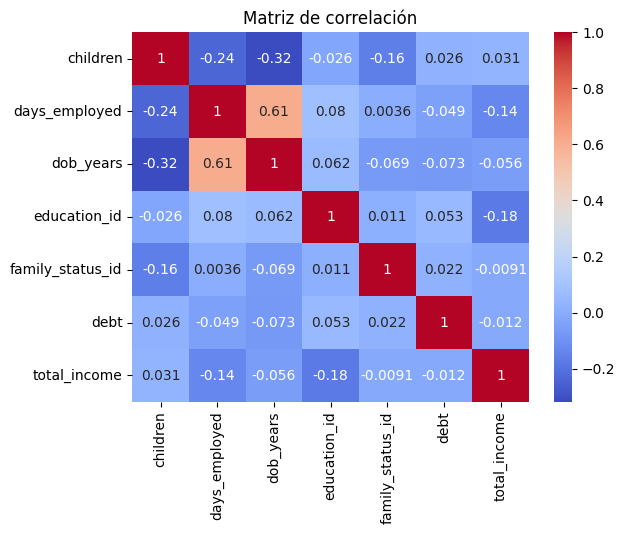

In [87]:
# calcular la matriz de correlación
corr = df[['children', 'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt', 'total_income']].corr()

# crear un heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

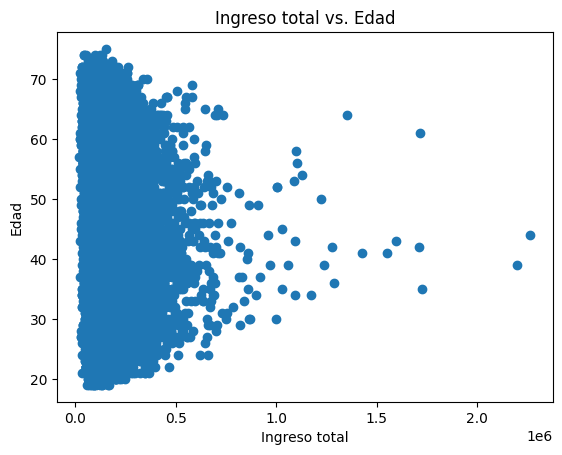

In [88]:
plt.scatter(df['total_income'], df['dob_years'])
plt.title('Ingreso total vs. Edad')
plt.xlabel('Ingreso total')
plt.ylabel('Edad')
plt.show()
